In [1]:
from pathlib import Path

import repath.data.datasets.camelyon16 as camelyon16
import repath.data.datasets.camelyon17 as camelyon17
from repath.postprocess.slide_level_metrics import SlideClassifierWang, SlideClassifierLee, SlideClassifierLiu
from repath.postprocess.results import SlidesIndexResults
from repath.utils.paths import project_root
from repath.utils.seeds import set_seed

In [2]:
experiment_name = "lee"
experiment_root = project_root() / "experiments" / experiment_name
global_seed = 123

In [3]:
set_seed(global_seed)

results_dir_name = "results"
heatmap_dir_name = "heatmaps"

resultsin_post = experiment_root / "train_index17" / "pre_hnm_results"

results_out_post = experiment_root / "train_index17" / "pre_hnm_results" /  "slide_results"

title_post = experiment_name + " experiment, post hnm model, Camelyon 17 valid dataset"

valid_results_post = SlidesIndexResults.load(camelyon17.training(), resultsin_post, results_dir_name, heatmap_dir_name)
#valid_results_post.patches = valid_results_post.patches[90:120]
#valid_results_post.patches = valid_results_post.patches[95:100]

In [4]:
#slide_classifier = SlideClassifierWang(results_out_post, camelyon17.training().slide_labels)

In [5]:
#slide_classifier.calc_features(valid_results_post)

In [6]:
#slide_classifier.predict_slide_level(retrain=True)

In [7]:
#slide_classifier.calc_slide_metrics(title_post)

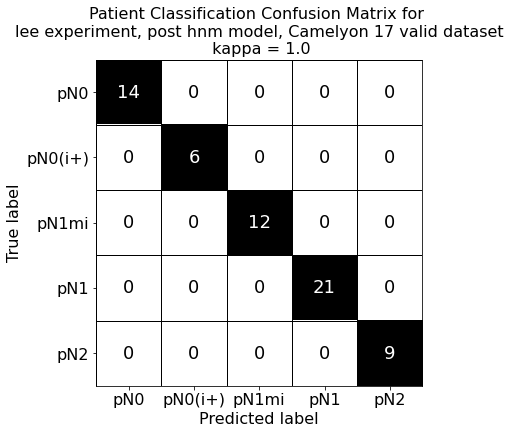

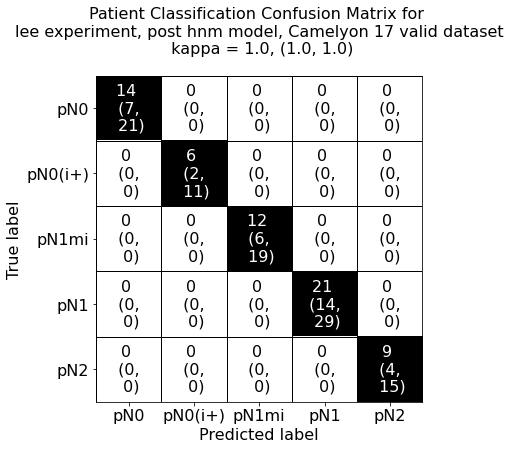

In [8]:
from repath.postprocess.patient_level_metrics import calc_patient_level_metrics, compute_patient_level_scores

calc_patient_level_metrics(results_out_post, title_post)

In [9]:
import pandas as pd
slide_results = pd.read_csv(results_out_post / 'slide_results.csv')
unique_patients = compute_patient_level_scores(slide_results)
unique_patients

,patient,predicted_stage,true_stage
0,patient_000,pN0,pN0
1,patient_001,pN0,pN0
2,patient_003,pN0,pN0
3,patient_004,pN0(i+),pN0(i+)
4,patient_005,pN0(i+),pN0(i+)
...,...,...,...
57,patient_094,pN2,pN2
58,patient_095,pN1,pN1
59,patient_097,pN2,pN2
60,patient_098,pN0,pN0


In [10]:
from repath.utils.metrics import conf_mat_raw

patient_labels = ['pN0', 'pN0(i+)', 'pN1mi', 'pN1', 'pN2']

conf_mat = conf_mat_raw(unique_patients.true_stage.to_numpy(), unique_patients.predicted_stage.to_numpy(), labels=patient_labels)

conf_mat

array([[14,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 0,  0, 12,  0,  0],
       [ 0,  0,  0, 21,  0],
       [ 0,  0,  0,  0,  9]])

In [11]:
unique_patients.true_stage.to_numpy()

array(['pN0', 'pN0', 'pN0', 'pN0(i+)', 'pN0(i+)', 'pN1mi', 'pN1mi',
       'pN1mi', 'pN1', 'pN1', 'pN1', 'pN1', 'pN1', 'pN2', 'pN1',
       'pN0(i+)', 'pN0', 'pN2', 'pN2', 'pN1', 'pN1mi', 'pN1mi', 'pN1',
       'pN1', 'pN0', 'pN1mi', 'pN1', 'pN0(i+)', 'pN1', 'pN0', 'pN1',
       'pN1mi', 'pN2', 'pN2', 'pN0', 'pN0', 'pN0', 'pN0', 'pN0', 'pN1mi',
       'pN2', 'pN0(i+)', 'pN1mi', 'pN0(i+)', 'pN1', 'pN1mi', 'pN1', 'pN1',
       'pN1', 'pN1mi', 'pN0', 'pN1', 'pN0', 'pN1mi', 'pN1', 'pN2', 'pN1',
       'pN2', 'pN1', 'pN2', 'pN0', 'pN1'], dtype=object)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def conf_mat_plot_heatmap(cm, display_labels, title_in, heatmap_type='true'):
    fig, ax = plt.subplots(figsize=(8,6))
    n_classes = cm.shape[0]
    cmap = 'Greys'

    if heatmap_type == 'percent':
        sum_vals = np.sum(cm)
    elif heatmap_type == 'true':
        sum_vals = np.reshape(np.repeat(np.sum(cm, axis=1), n_classes), (n_classes, n_classes))
    elif heatmap_type == 'pred':
        sum_vals = np.reshape(np.tile(np.sum(cm, axis=0), n_classes), (n_classes, n_classes))
        print(sum_vals)

    color_mapping = np.array(np.multiply(np.divide(cm, sum_vals), 255), np.uint8)
    print(color_mapping)

    for i in range(n_classes):
        for j in range(n_classes):
            text_cm = format(cm[i, j], ',')
            txt_color = [1, 1, 1] if color_mapping[i, j] > 100 else [0, 0, 0]
            ax.text(j, i, text_cm, ha="center", va="center", color=txt_color, fontsize=18)
            ax.axhline(i - 0.5, color='black', linewidth=1.0)
            ax.axvline(j - 0.5, color='black', linewidth=1.0)

    ax.matshow(color_mapping, cmap=cmap)

    ax.set_xlabel("Predicted label", fontsize=16)
    ax.set_ylabel("True label", fontsize=16)
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(display_labels, fontsize=16)
    ax.set_yticklabels(display_labels, fontsize=16)
    ax.set_title(title_in, fontsize=16)
    ax.tick_params(bottom=True, labelbottom=True, top=False, labeltop=False)

    ax.set_ylim((n_classes - 0.5, -0.5))

    return ax

In [13]:
patient_metrics_out = pd.read_csv(results_out_post / 'patient_metrics.csv', index_col=0)
patient_metrics_out

,kappa,true_pN0_pred_pN0,true_pN0_pred_pN0(i+),true_pN0_pred_pN1mi,true_pN0_pred_pN1,true_pN0_pred_pN2,true_pN0(i+)_pred_pN0,true_pN0(i+)_pred_pN0(i+),true_pN0(i+)_pred_pN1mi,true_pN0(i+)_pred_pN1,...,true_pN1_pred_pN0,true_pN1_pred_pN0(i+),true_pN1_pred_pN1mi,true_pN1_pred_pN1,true_pN1_pred_pN2,true_pN2_pred_pN0,true_pN2_pred_pN0(i+),true_pN2_pred_pN1mi,true_pN2_pred_pN1,true_pN2_pred_pN2
results,1.0,14.000,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,9.0
ci_lower_bound,1.0,7.975,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,4.0
ci_upper_bound,1.0,21.000,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,15.0
sample_0,1.0,14.000,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,12.0
sample_1,1.0,9.000,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_995,1.0,18.000,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,11.0
sample_996,1.0,18.000,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,8.0
sample_997,1.0,18.000,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,8.0
sample_998,1.0,9.000,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,8.0


[[255   0   0   0   0]
 [  0 255   0   0   0]
 [  0   0 255   0   0]
 [  0   0   0 255   0]
 [  0   0   0   0 255]]


<AxesSubplot:title={'center':'lee experiment, post hnm model, Camelyon 17 valid dataset'}, xlabel='Predicted label', ylabel='True label'>

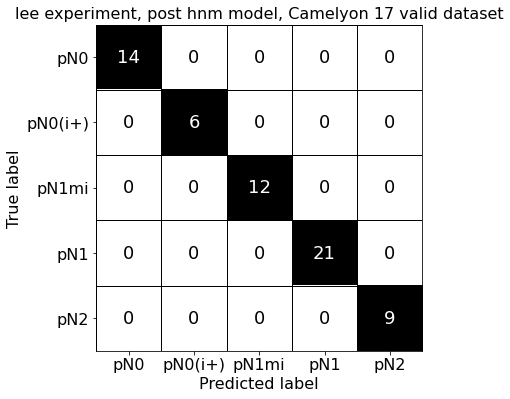

In [14]:
cm = patient_metrics_out.iloc[:, 1:]
cm_all = cm.loc['results', :].to_numpy()
cm_all = np.reshape(np.array(cm_all, dtype=np.int), (5, 5))

conf_mat_plot_heatmap(cm_all, patient_labels, title_post)